In [1]:
import os

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models
from keras import optimizers
from keras import applications
from keras import preprocessing
from keras import callbacks
from keras import layers
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

2024-05-18 04:07:15.264665: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 04:07:15.295635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 04:07:15.295674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 04:07:15.296554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 04:07:15.302896: I tensorflow/core/platform/cpu_feature_guar

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-18 04:07:16.455207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 04:07:16.497890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 04:07:16.497935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Bootstrap

**Removendo Arquivos Indesejados**

Remover arquivos que não são imagens para previnir que os mesmo possam entrar na rede durante o treinamento e ocasionar problemas.

In [4]:
num_skipped = 0
for folder_name in ("valid", "test", "train"):
    for sub_folder_name in ("anabele", "chris", "diniz", "manuela", "matheus", "michel", "pablo"):
        folder_name_aux = os.path.join(folder_name, sub_folder_name)
        print(folder_name_aux)
        folder_path = os.path.join("images/tatuagens/", folder_name_aux)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                print(fpath)
                fobj = open(fpath, "rb")
                is_jfif = b"JFIF" in fobj.peek(10)
            finally:
                fobj.close()
    
            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)
        folder_name_aux = ""
print(f"Deleted {num_skipped} images.")


valid/anabele
images/tatuagens/valid/anabele/anabele8.jpg
images/tatuagens/valid/anabele/anabele9.jpg
images/tatuagens/valid/anabele/anabele28.jpg
images/tatuagens/valid/anabele/anabele46.jpg
images/tatuagens/valid/anabele/anabele1.jpg
images/tatuagens/valid/anabele/anabele20.jpg
images/tatuagens/valid/anabele/anabele11.jpg
images/tatuagens/valid/anabele/anabele6.jpg
images/tatuagens/valid/anabele/anabele12.jpg
images/tatuagens/valid/anabele/anabele30.jpg
images/tatuagens/valid/anabele/anabele33.jpg
images/tatuagens/valid/anabele/anabele43.jpg
images/tatuagens/valid/anabele/anabele29.jpg
images/tatuagens/valid/anabele/anabele2.jpg
images/tatuagens/valid/anabele/anabele17.jpg
images/tatuagens/valid/anabele/anabele25.jpg
images/tatuagens/valid/anabele/anabele39.jpg
images/tatuagens/valid/anabele/anabele26.jpg
images/tatuagens/valid/anabele/anabele14.jpg
images/tatuagens/valid/anabele/anabele7.jpg
images/tatuagens/valid/anabele/anabele3.jpg
images/tatuagens/valid/anabele/anabele31.jpg
ima

**Aplicando Pré-processamento**

Aplicando o vgg19.preprocess_input para que as imgens sofram o mesmo tipo de pré-processamento do treinamento.

In [5]:
# Definindo os diretórios das imagens
base_dir = 'images/tatuagens/'

In [6]:
# Definindo as dimensões da imagem
img_height, img_width = 224, 224
batch_size = 32

In [7]:
# Definindo o pré-processamento para geração de dados
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

In [8]:
# Treinamento do gerador de dados
train_generator = datagen.flow_from_directory(
    base_dir + '/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# Validação do gerador de dados
validation_generator = datagen.flow_from_directory(
    base_dir + '/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# Teste do gerador de dados
test_generator = datagen.flow_from_directory(
    base_dir + '/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.
Found 166 images belonging to 7 classes.


**Função para Criar o Modelo**

In [9]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = applications.VGG19(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = layers.Flatten(name="flatten")(top_model)
    top_model = layers.Dense(4096, activation='relu')(top_model)
    top_model = layers.Dropout(0.3)(top_model)
    top_model = layers.Dense(1072, activation='relu')(top_model)
    top_model = layers.Dropout(0.2)(top_model)
    output_layer = layers.Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = models.Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
BATCH_SIZE = 32

input_shape = (224, 224, 3)
optim_1 = optimizers.Adam(learning_rate=0.0001)
n_classes=7

n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = validation_generator.samples // BATCH_SIZE
n_epochs = 50

2024-05-18 04:07:16.681870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 04:07:16.681960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 04:07:16.681976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 04:07:16.780432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 04:07:16.780492: I external/local_xla/xla/stream_executor

In [11]:
print(n_steps)

41


In [12]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_v1.weights.h5',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [13]:
# Use a smaller learning rate
#optim = Adam(lr=0.0001)

# Just Feature Extraction
vgg_model_ft = create_model(input_shape, n_classes, optim_1, fine_tune=0)

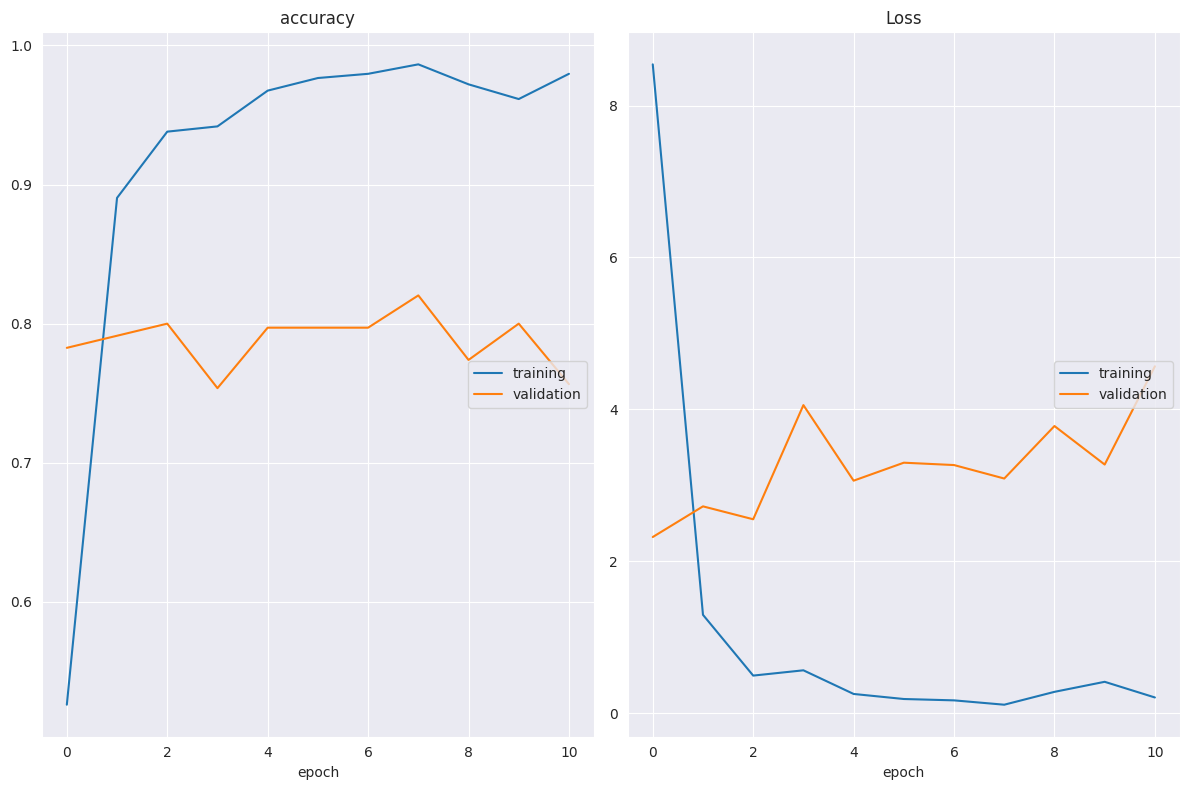

accuracy
	training         	 (min:    0.526, max:    0.986, cur:    0.980)
	validation       	 (min:    0.754, max:    0.820, cur:    0.757)
Loss
	training         	 (min:    0.110, max:    8.543, cur:    0.205)
	validation       	 (min:    2.318, max:    4.566, cur:    4.566)
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 266ms/step - accuracy: 0.9847 - loss: 0.1556 - val_accuracy: 0.7565 - val_loss: 4.5663
CPU times: user 2min 26s, sys: 12.1 s, total: 2min 38s
Wall time: 2min 15s


In [44]:
%%time

plot_loss = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(train_generator,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_generator,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss],
                                  verbose=1)

**Acurácia de Teste**

In [29]:
#from sklearn.metrics import accuracy_score

vgg_model_ft.load_weights('./modelsaved/tl_model_v1.weights.h5')
vgg_preds_ft = vgg_model_ft.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes = np.argmax(vgg_preds_ft, axis=1)
print(predicted_classes)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy = np.mean(predicted_classes == true_classes)
print(accuracy)

accuracy_sk = accuracy_score(true_classes, predicted_classes)
print(accuracy_sk)

print(f"Acurácia: {accuracy * 100:.2f}%")

/home/iago/posgraduacao/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/iago/posgraduacao/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-17 02:32:01.632933: I external/local_xla/xla/service/service.cc:168] XLA service 0x556b08a18660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 02:32:01.632989: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4

2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

I0000 00:00:1715923935.505985   89496 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 636ms/step
[0 0 0 0 0 0 0 1 0 0 2 0 2 0 0 0 0 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 6 6 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 6 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2 6 2 2 3 3
 1 3 3 3 3 3 1 3 3 3 1 3 3 3 1 3 3 3 4 5 5 4 1 4 4 5 4 6 4 0 4 6 4 4 4 4 4
 5 5 4 5 5 5 4 5 5 5 5 5 5 6 5 5 5 5 3 5 5 5 5 5 4 5 5 6 6 2 6 5 6 6 6 6 6
 6 6 6 6 6 6 6 2 6 6 6 6 6 6 1 6 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.8192771084337349
0.8192771084337349
Acurácia: 81.93%


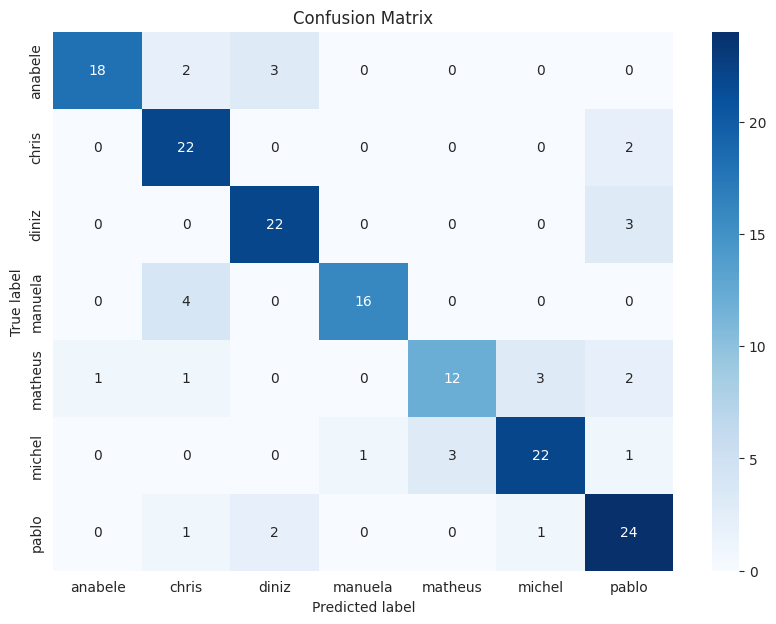

In [30]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.metrics import confusion_matrix

# get the confusion matrix
matrix = confusion_matrix(true_classes, predicted_classes)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Fine Tuning

**Salvando os Pesos do Modelo**

In [14]:
plot_loss_2 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_finetuning.weights.h5',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

In [31]:
# Reset our image data generators
train_generator.reset() 
validation_generator.reset() 
test_generator.reset()

optim_2 = optimizers.Adam(learning_rate=0.0001)

# Just Feature Extraction
vgg_model_ft_2 = create_model(input_shape, n_classes, optim_2, fine_tune=3)

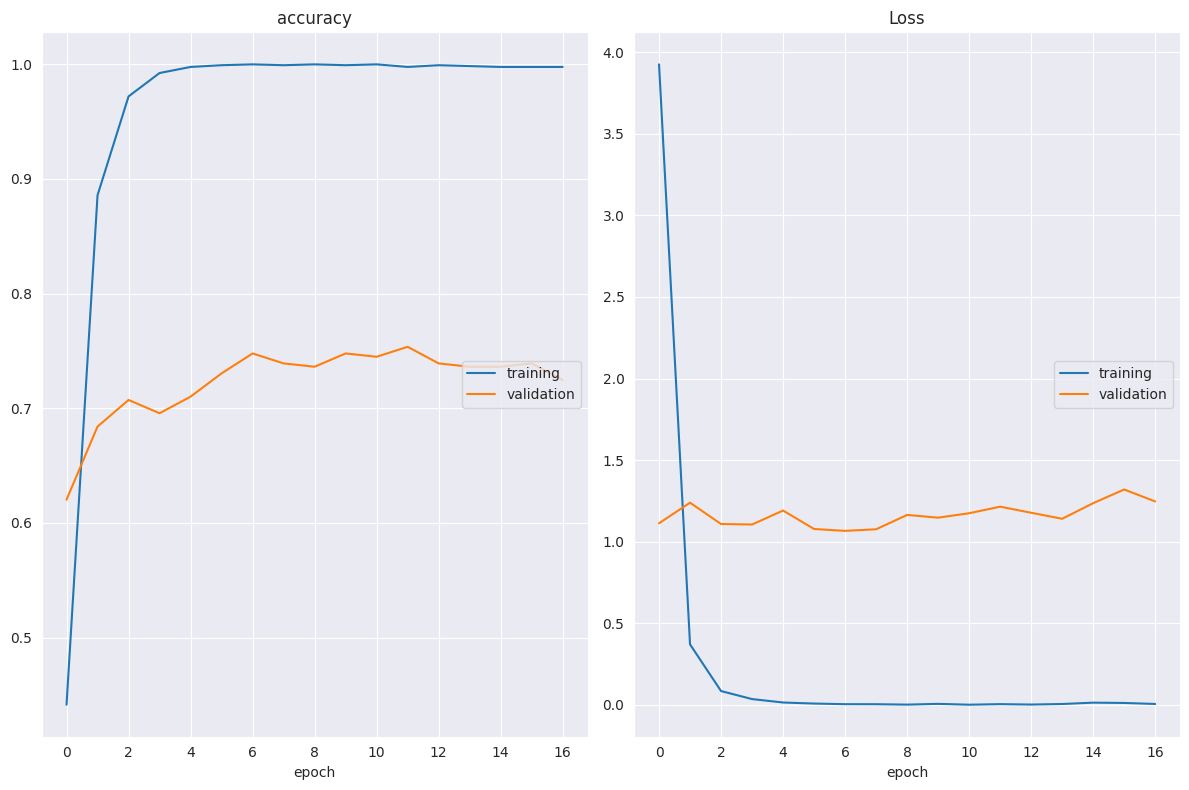

accuracy
	training         	 (min:    0.441, max:    1.000, cur:    0.998)
	validation       	 (min:    0.620, max:    0.754, cur:    0.725)
Loss
	training         	 (min:    0.001, max:    3.926, cur:    0.006)
	validation       	 (min:    1.067, max:    1.320, cur:    1.247)
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.9970 - loss: 0.0073 - val_accuracy: 0.7246 - val_loss: 1.2469
CPU times: user 3min 45s, sys: 22.5 s, total: 4min 7s
Wall time: 3min 32s


In [17]:
%%time

plot_loss_finetuning = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_2 = vgg_model_ft_2.fit(train_generator,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_generator,
                                  callbacks=[tl_checkpoint_2, early_stop, plot_loss_finetuning],
                                  verbose=1)

tf.keras.backend.clear_session(free_memory=True)


**Acurácia de Teste**

In [32]:
vgg_model_ft_2.load_weights('./modelsaved/tl_model_finetuning.weights.h5')
vgg_preds_ft_2 = vgg_model_ft_2.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes_2 = np.argmax(vgg_preds_ft_2, axis=1)
print(predicted_classes_2)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy_2 = np.mean(predicted_classes_2 == true_classes)
print(accuracy_2)

accuracy_sk_2 = accuracy_score(true_classes, predicted_classes_2)
print(accuracy_sk_2)

print(f"Acurácia: {accuracy_2 * 100:.2f}%")

/home/iago/posgraduacao/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 3 1 1 1 1 1 2 1 6 1 1 1 1
 1 1 1 1 2 1 1 1 5 1 2 2 2 2 2 2 2 6 2 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 4 3 3 3 3 3 3 4 3 3 1 3 4 3 1 3 3 3 4 5 6 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4
 4 5 4 5 5 5 4 5 5 5 5 5 5 5 5 5 5 4 5 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 6 1 6 6 6 6 6 2 6 6 6 6 6 6 1 6 6 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.8433734939759037
0.8433734939759037
Acurácia: 84.34%


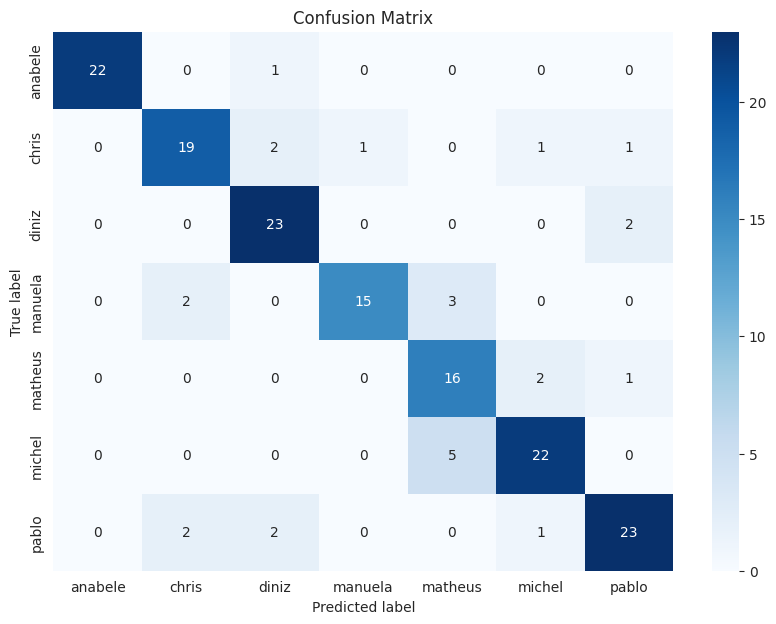

In [33]:
# get the confusion matrix
matrix_2 = confusion_matrix(true_classes, predicted_classes_2)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_2, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Pré-processamento Realce e Bootstrap

In [16]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.util import img_as_ubyte
from skimage.filters import unsharp_mask
from pathlib import Path

**Função para Fazer o Pré-processamento**

Utilizando o Unshapr_mask da biblioteca scikit-image

In [35]:
def process_images(input_dir, output_dir):
    # Criar o diretório de saída se ele não existe
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Lista com os nomes das classes
    classes = ["anabele", "chris", "diniz", "manuela", "matheus", "michel", "pablo"]

    # Loop pelas pastas de treinamento, teste e validação
    for folder in ['train', 'test', 'valid']:
        for class_name in classes:
            # Definir path do diretório de entrada e saída
            input_path = Path(input_dir) / "tatuagens" / folder / class_name
            output_path = Path(output_dir) / folder / class_name
                        
            # Criar o diretório de saída para a classe atual se não existir
            output_path.mkdir(parents=True, exist_ok=True)

            # Obter uma lista de todas as imagens .jpg no diretório de entrada
            image_files = list(input_path.rglob('*.jpg'))
            print(image_files)
            
            # Loop em todas as imagens .jpg
            for image_file in image_files:
                # Ler a imagem
                image = io.imread(image_file)

                # Aplicar o filtro unsharp mask
                sharpened = unsharp_mask(image, radius=1.0, amount=1.0)

                # Converta a imagem processada para 8 bits unsigned byte format
                sharpened = img_as_ubyte(sharpened)

                # Salvar a imagem processada no diretório de saída
                io.imsave(output_path / image_file.name, sharpened)

In [95]:
# Chama a função com seu diretório de entrada e saída
process_images('images', 'PreProcessImages')

[PosixPath('images/tatuagens/train/anabele/anabele (52).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (115).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (166).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (137).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (116).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (44).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (110).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (35).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (22).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (131).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (37).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (82).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (111).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (119).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (89).jpg'), PosixPath('images/tatuagens/train/anabele/anabele (143).jpg')

In [14]:
# Definindo os diretórios das imagens
base_dir_pre = 'PreProcessImages'

**Aplicando Pré-processamento**

Aplicando o vgg19.preprocess_input para que as imgens sofram o mesmo tipo de pré-processamento do treinamento.

In [15]:
# Definindo o pré-processamento para geração de dados
datagen_pre = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

In [16]:
# Treinamento do gerador de dados
train_generator_pre = datagen_pre.flow_from_directory(
    base_dir_pre + '/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# Validação do gerador de dados
validation_generator_pre = datagen_pre.flow_from_directory(
    base_dir_pre + '/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# Teste do gerador de dados
test_generator_pre = datagen_pre.flow_from_directory(
    base_dir_pre + '/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.
Found 166 images belonging to 7 classes.


**Salvando os Pesos do Modelo**

In [46]:
plot_loss_3 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_3 = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_preprocess.weights.h5',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

In [47]:
# Reset our image data generators
#train_generator_pre.reset() 
#validation_generator_pre.reset() 
#test_generator_pre.reset()

optim_3 = optimizers.Adam(learning_rate=0.0001)

# Just Feature Extraction
vgg_model_ft_3 = create_model(input_shape, n_classes, optim_3, fine_tune=0)

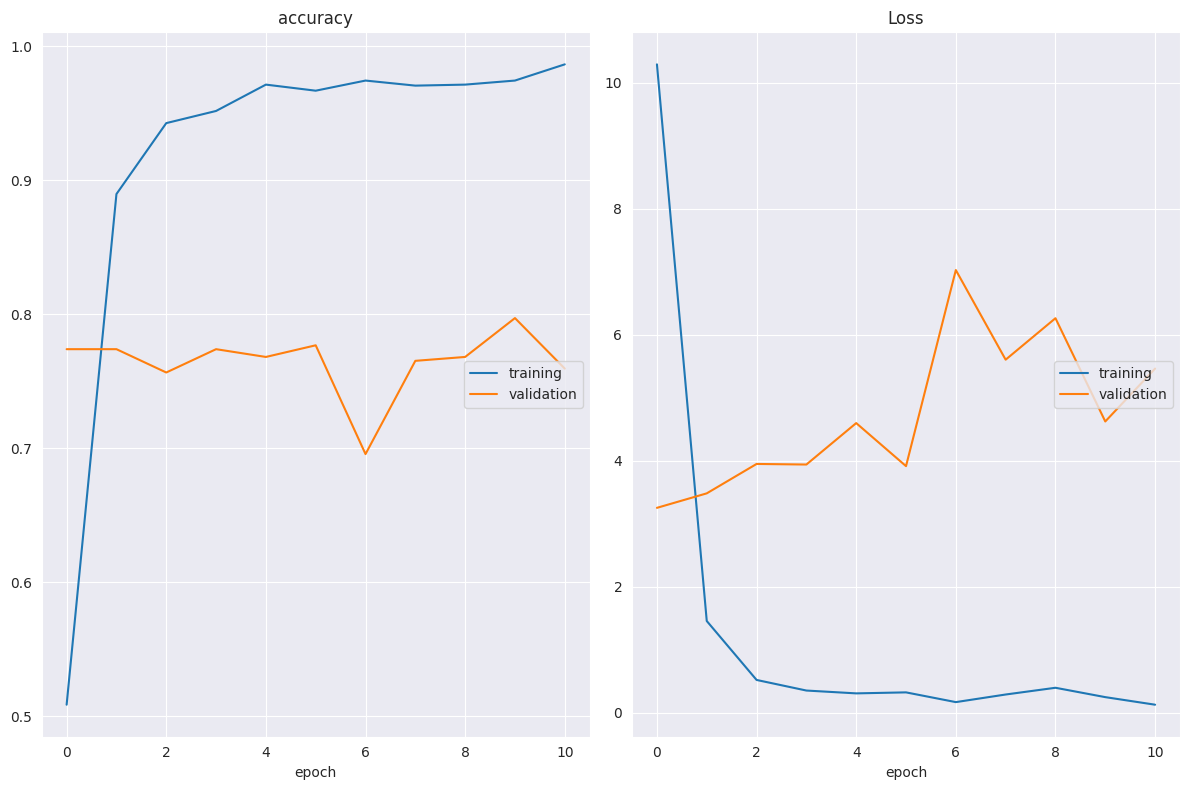

accuracy
	training         	 (min:    0.509, max:    0.986, cur:    0.986)
	validation       	 (min:    0.696, max:    0.797, cur:    0.759)
Loss
	training         	 (min:    0.131, max:   10.289, cur:    0.131)
	validation       	 (min:    3.254, max:    7.026, cur:    5.463)
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.9829 - loss: 0.1618 - val_accuracy: 0.7594 - val_loss: 5.4629
CPU times: user 2min 18s, sys: 9.36 s, total: 2min 28s
Wall time: 2min 3s


In [48]:
%%time

plot_loss_pre = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_3 = vgg_model_ft_3.fit(train_generator_pre,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_generator_pre,
                                  callbacks=[tl_checkpoint_3, early_stop, plot_loss_pre],
                                  verbose=1)

tf.keras.backend.clear_session(free_memory=True)

**Acurácia de Teste**

In [49]:
from sklearn.metrics import accuracy_score

vgg_model_ft_3.load_weights('./modelsaved/tl_model_preprocess.weights.h5')
vgg_preds_ft_3 = vgg_model_ft_3.predict(test_generator_pre)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes_3 = np.argmax(vgg_preds_ft_3, axis=1)
print(predicted_classes_3)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator_pre.classes
print(true_classes)

# calcula a acurácia
accuracy_3 = np.mean(predicted_classes_3 == true_classes)
print(accuracy_3)

accuracy_sk_3 = accuracy_score(true_classes, predicted_classes_3)
print(accuracy_sk_3)

print(f"Acurácia: {accuracy_3 * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
[0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 3 1 1 1 1 1 2 6 5 1 1
 1 3 1 1 2 1 1 1 5 1 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 6 2 2 2 3 3
 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 5 5 4 3 4 3 5 4 3 5 3 3 5 5 3 4 4 3
 5 5 5 5 4 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 6 6 2 6 6 6 6 6 5 6
 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.7951807228915663
0.7951807228915663
Acurácia: 79.52%


**Matriz de Confusão**

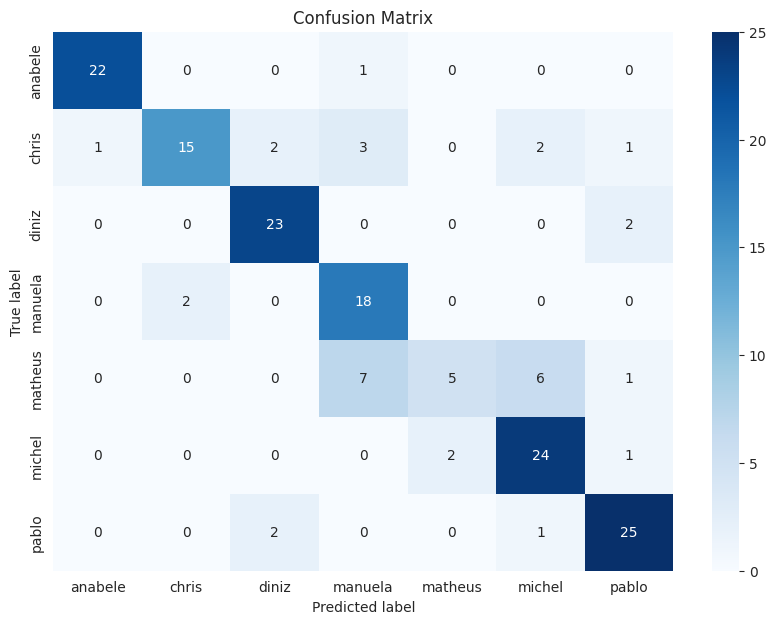

In [50]:
# get the confusion matrix
matrix_3 = confusion_matrix(true_classes, predicted_classes_3)

# Get class labels
class_labels = list(test_generator_pre.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_3, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Pré-processamento Realce e Fine Tuning 

**Salvando os Pesos do Modelo**

In [20]:
plot_loss_4 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_4 = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_preprocess_ft.weights.h5',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

In [21]:
# Reset our image data generators
#train_generator_pre.reset() 
#validation_generator_pre.reset() 
#test_generator_pre.reset()

optim_4 = optimizers.Adam(learning_rate=0.0001)

# Just Feature Extraction
vgg_model_ft_4 = create_model(input_shape, n_classes, optim_4, fine_tune=3)

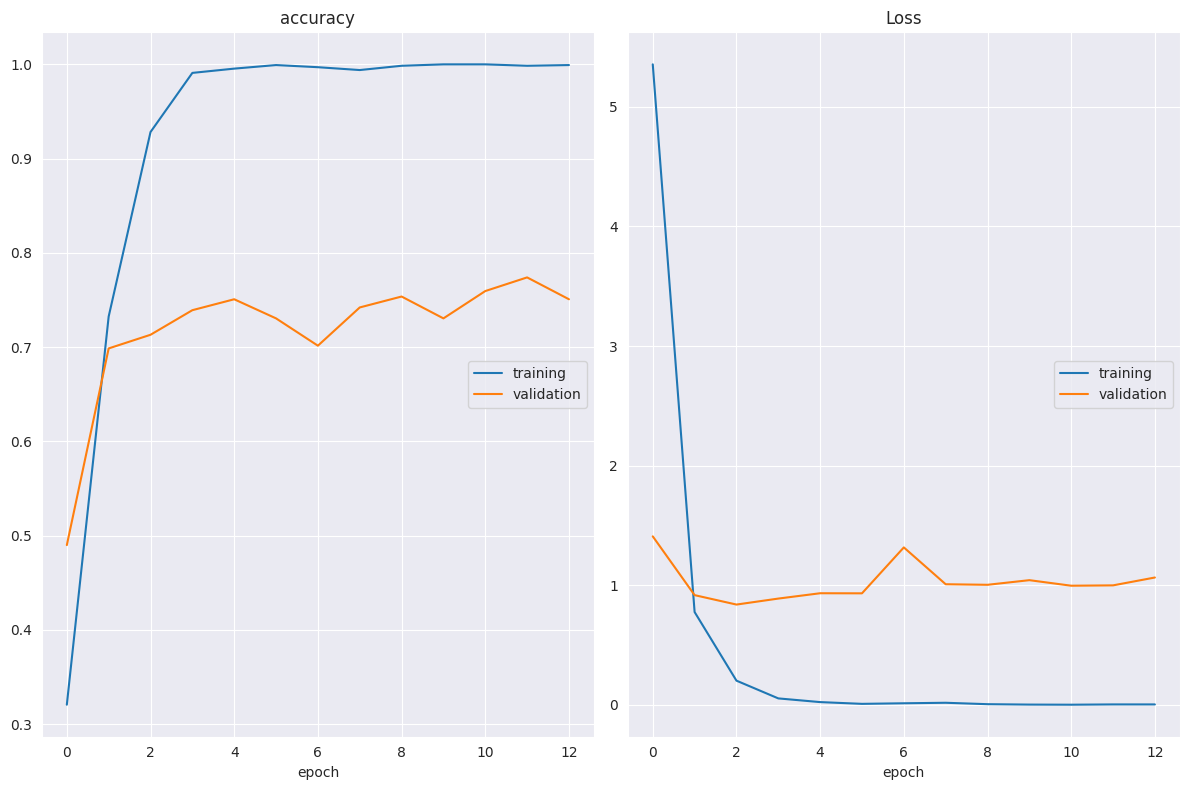

accuracy
	training         	 (min:    0.320, max:    1.000, cur:    0.999)
	validation       	 (min:    0.490, max:    0.774, cur:    0.751)
Loss
	training         	 (min:    0.001, max:    5.355, cur:    0.004)
	validation       	 (min:    0.838, max:    1.409, cur:    1.065)
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9982 - loss: 0.0047 - val_accuracy: 0.7507 - val_loss: 1.0647
CPU times: user 2min 50s, sys: 10.2 s, total: 3min 1s
Wall time: 2min 26s


In [22]:
%%time

plot_loss_pre_ft = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_4 = vgg_model_ft_4.fit(train_generator_pre,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_generator_pre,
                                  callbacks=[tl_checkpoint_4, early_stop, plot_loss_pre_ft],
                                  verbose=1)

tf.keras.backend.clear_session(free_memory=True)

**Acurácia de Teste**

In [23]:
from sklearn.metrics import accuracy_score

vgg_model_ft_4.load_weights('./modelsaved/tl_model_preprocess_ft.weights.h5')
vgg_preds_ft_4 = vgg_model_ft_4.predict(test_generator_pre)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes_4 = np.argmax(vgg_preds_ft_4, axis=1)
print(predicted_classes_4)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator_pre.classes
print(true_classes)

# calcula a acurácia
accuracy_4 = np.mean(predicted_classes_4 == true_classes)
print(accuracy_4)

accuracy_sk_4 = accuracy_score(true_classes, predicted_classes_4)
print(accuracy_sk_4)

print(f"Acurácia: {accuracy_4 * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step
[3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 4 1 1 1 1 0 6 5 1 2 1
 3 5 1 3 3 1 1 1 4 6 4 6 2 2 2 4 2 2 3 2 2 6 2 2 2 2 2 2 2 1 2 2 2 2 6 3 3
 4 3 3 4 3 3 3 3 3 3 3 3 3 3 4 3 5 5 4 5 6 4 3 2 4 4 4 3 4 4 4 4 4 4 4 4 4
 4 3 5 5 4 5 5 5 5 5 5 5 1 5 4 5 5 4 5 4 4 5 4 5 4 5 5 6 2 6 6 6 6 6 6 5 6
 2 6 2 6 6 6 6 6 6 6 6 2 1 6 6 6 6 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.7108433734939759
0.7108433734939759
Acurácia: 71.08%


**Matriz de Confusão**

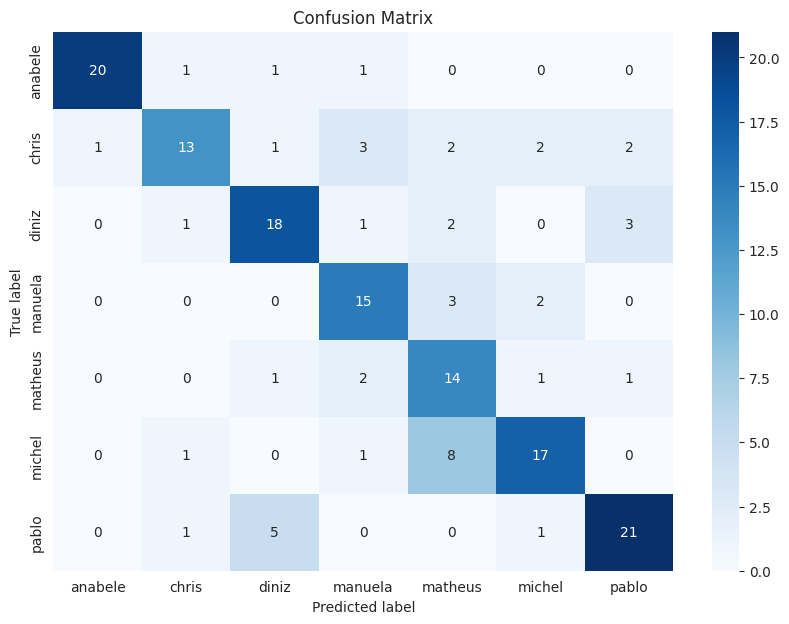

In [24]:
# get the confusion matrix
matrix_4 = confusion_matrix(true_classes, predicted_classes_4)

# Get class labels
class_labels = list(test_generator_pre.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_4, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Pré-processamento Suavização e Bootstrap

**Salvando o Modelo e Utilização do EarlyStop**

In [14]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_pre_su = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_pre_su = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_pre_su.weights.h5',
                                            save_best_only=True,
                                            save_weights_only=True,
                                            verbose=1)

# EarlyStopping
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     patience=10,
                                     restore_best_weights=True,
                                     mode='min')

**Função para Aplicar o Pré-processamento de Suavização nas Imagens**

In [15]:
import cv2
def enhance_contrast(image):
    #if len(image.shape) == 3 and image.shape[2] == 3:
        # Converter a imagem para escala de cinza
    #    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #else:
    #    gray = image

    # Realce de Contraste (Equalização de Histograma)
    #enhanced = cv2.equalizeHist(gray)

    smoothed = cv2.GaussianBlur(image, (5, 5), 0)
    # Converter de volta para o formato RGB
    #enhanced_rgb = cv2.cvtColor(smoothed, cv2.COLOR_GRAY2BGR)

    # Aplicar preprocess_input do VGG19
    preprocessed = tf.keras.applications.vgg19.preprocess_input(smoothed)
    return preprocessed
# Definindo o pré-processamento para geração de dados

datagen_pre_su = tf.keras.preprocessing.image.ImageDataGenerator( #rotation_range=40,          # Rotação aleatória das imagens em até 40 graus
                              #width_shift_range=0.2,      # Deslocamento horizontal aleatório das imagens em até 20% da largura
                              #height_shift_range=0.2,     # Deslocamento vertical aleatório das imagens em até 20% da altura
                              #shear_range=0.2,            # Aplicação de corte nas imagens
                              #zoom_range=0.2,             # Aplicação de zoom nas imagens
                              #horizontal_flip=True,       # Inversão horizontal das imagens
                              #fill_mode='nearest',
                              preprocessing_function=enhance_contrast)#vgg19.preprocess_input)

In [16]:
# Treinamento do gerador de dados
train_generator_pre = datagen_pre_su.flow_from_directory(
    base_dir + '/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# Validação do gerador de dados
validation_generator_pre = datagen_pre_su.flow_from_directory(
    base_dir + '/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# Teste do gerador de dados
test_generator_pre = datagen_pre_su.flow_from_directory(
    base_dir + '/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.
Found 166 images belonging to 7 classes.


In [18]:
# Use a smaller learning rate
#optim = Adam(lr=0.0001)

# Just Feature Extraction
vgg_model_su = create_model(input_shape, n_classes, optim_1, fine_tune=0)

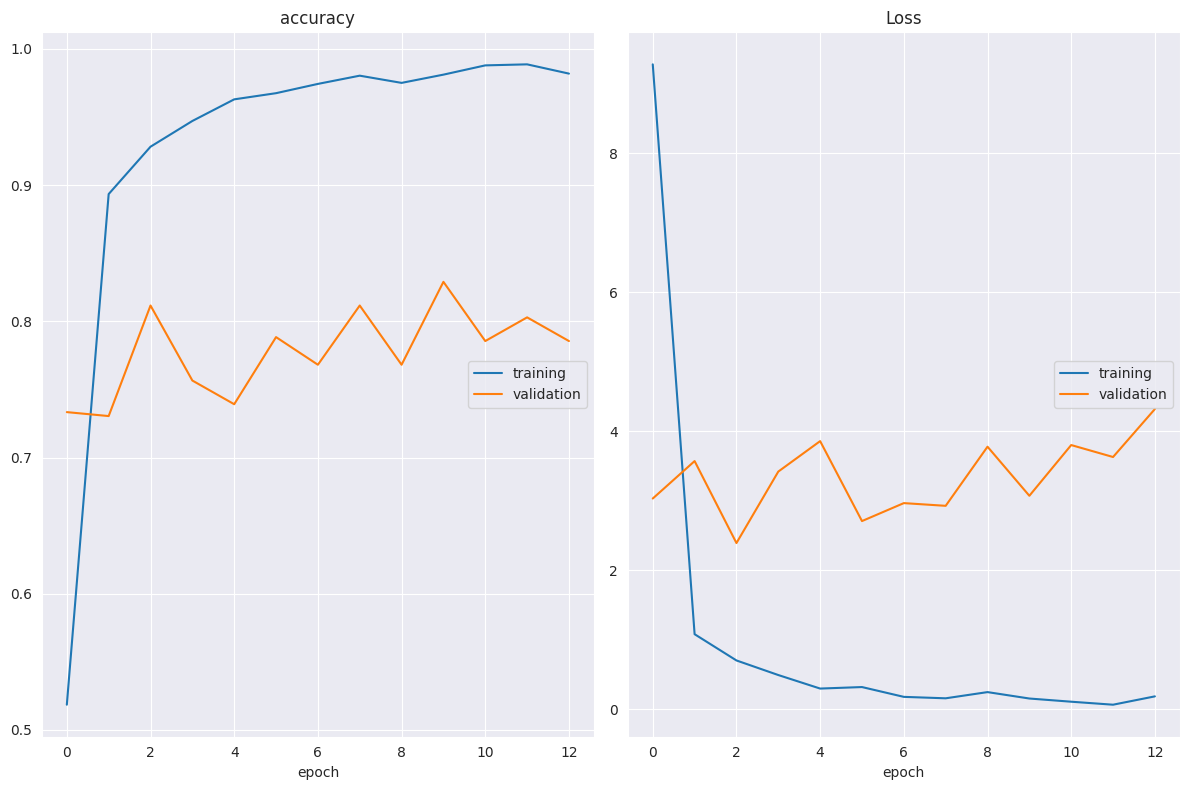

accuracy
	training         	 (min:    0.519, max:    0.989, cur:    0.982)
	validation       	 (min:    0.730, max:    0.829, cur:    0.786)
Loss
	training         	 (min:    0.066, max:    9.280, cur:    0.186)
	validation       	 (min:    2.392, max:    4.320, cur:    4.320)
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9790 - loss: 0.2050 - val_accuracy: 0.7855 - val_loss: 4.3205
CPU times: user 2min 44s, sys: 20.4 s, total: 3min 5s
Wall time: 2min 22s


In [19]:
%%time

plot_loss = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_an = vgg_model_su.fit(train_generator,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_generator,
                                  callbacks=[tl_checkpoint_pre_su, early_stop, plot_loss],
                                  verbose=1)

**Acurácia de Teste**

In [20]:
#from sklearn.metrics import accuracy_score

vgg_model_su.load_weights('./modelsaved/tl_model_pre_su.weights.h5')
vgg_preds_su = vgg_model_su.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes = np.argmax(vgg_preds_su, axis=1)
print(predicted_classes)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy = np.mean(predicted_classes == true_classes)
print(accuracy)

accuracy_sk = accuracy_score(true_classes, predicted_classes)
print(accuracy_sk)

print(f"Acurácia: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 546ms/step
[0 0 3 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 4 4 1 1 1 1 2 2 1 1 6 1 1 1
 1 1 1 1 2 1 1 1 5 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 4 4 1 4 3 1 3 4 3 3 1 1 3 3 1 3 3 3 4 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 5 5 5 5 5 6 5 5 5 5 5 5 5 5 4 5 4 4 4 5 5 5 5 5 5 4 6 6 2 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.8192771084337349
0.8192771084337349
Acurácia: 81.93%


**Matriz de Confusão**

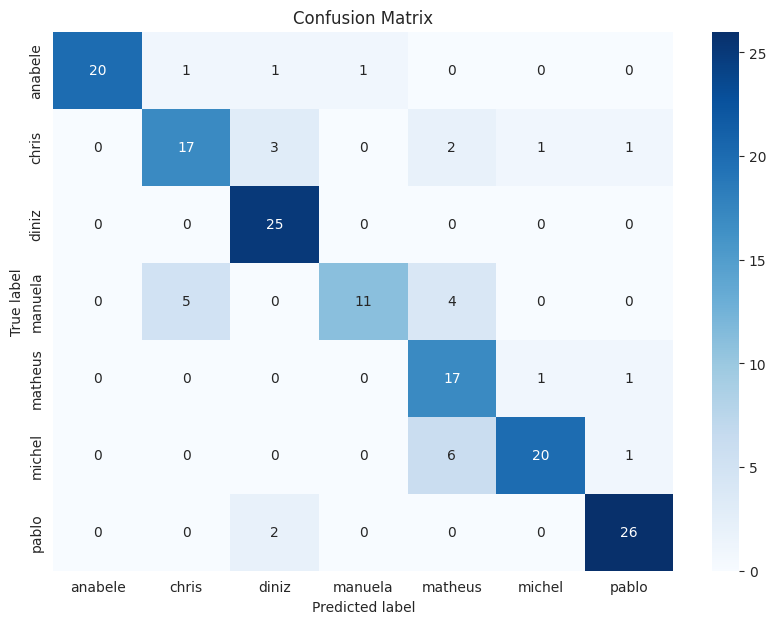

In [21]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.metrics import confusion_matrix

# get the confusion matrix
matrix = confusion_matrix(true_classes, predicted_classes)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Pré-processamento de Suavização e Fine Tuning

In [19]:
# Use a smaller learning rate
#optim = Adam(lr=0.0001)

# Just Feature Extraction
vgg_model_su_ft = create_model(input_shape, n_classes, optim_1, fine_tune=3)

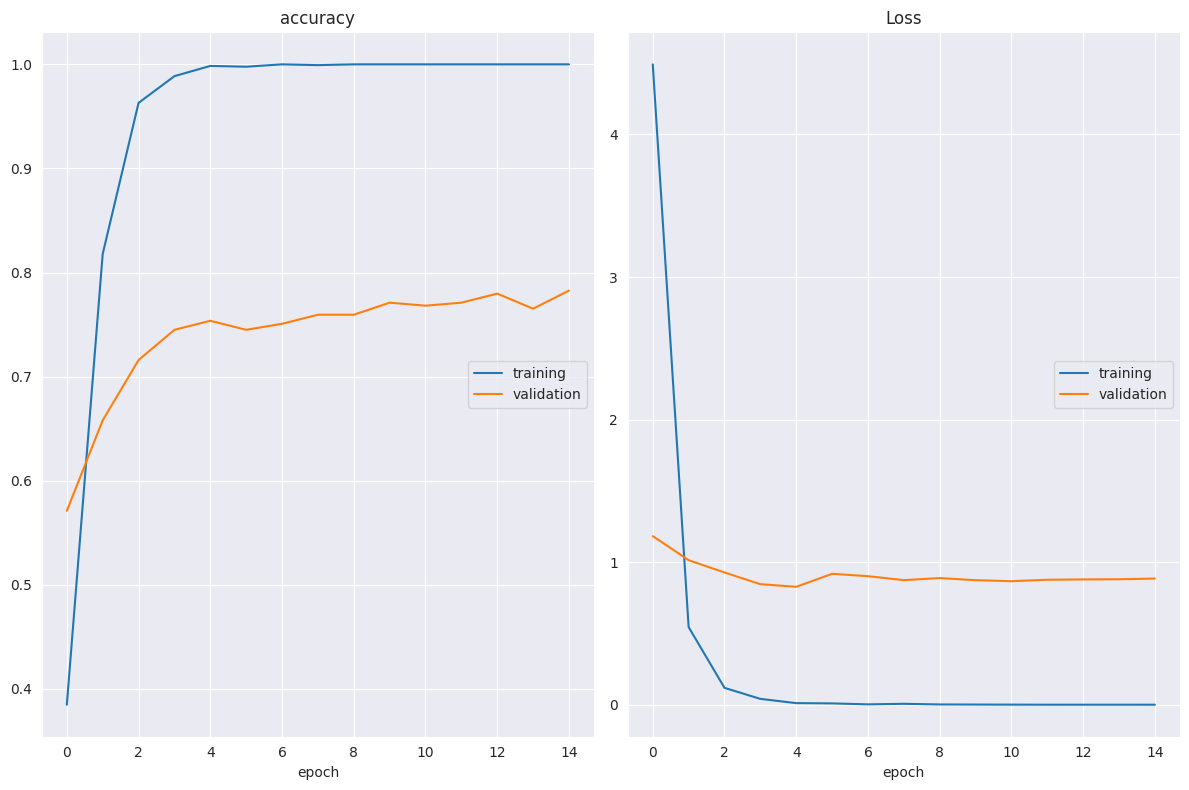

accuracy
	training         	 (min:    0.385, max:    1.000, cur:    1.000)
	validation       	 (min:    0.571, max:    0.783, cur:    0.783)
Loss
	training         	 (min:    0.000, max:    4.492, cur:    0.000)
	validation       	 (min:    0.827, max:    1.183, cur:    0.885)
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 1.0000 - loss: 4.7841e-04 - val_accuracy: 0.7826 - val_loss: 0.8853
CPU times: user 3min 25s, sys: 12.2 s, total: 3min 37s
Wall time: 2min 59s


In [20]:
%%time

plot_loss = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_an = vgg_model_su_ft.fit(train_generator,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_generator,
                                  callbacks=[tl_checkpoint_pre_su, early_stop, plot_loss],
                                  verbose=1)

**Acurácia de Teste**

In [21]:
#from sklearn.metrics import accuracy_score

vgg_model_su.load_weights('./modelsaved/tl_model_pre_su.weights.h5')
vgg_preds_su = vgg_model_su.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes = np.argmax(vgg_preds_su, axis=1)
print(predicted_classes)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy = np.mean(predicted_classes == true_classes)
print(accuracy)

accuracy_sk = accuracy_score(true_classes, predicted_classes)
print(accuracy_sk)

print(f"Acurácia: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step
[0 0 0 0 0 0 0 5 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 4 1 1 5 1 3 1 2 0 6 1 1 6 1
 1 1 1 1 3 1 1 1 2 1 2 2 2 6 2 2 2 2 2 2 2 6 2 2 2 2 2 6 2 2 2 2 2 2 2 3 3
 1 4 1 3 3 3 3 3 3 3 1 1 3 3 4 3 3 4 4 1 5 4 4 4 4 1 4 4 4 4 3 4 4 4 4 4 4
 4 5 5 5 4 5 4 5 5 5 5 5 5 5 4 5 5 4 5 4 4 4 4 5 5 5 5 6 0 6 6 6 6 6 6 5 6
 6 1 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.7710843373493976
0.7710843373493976
Acurácia: 77.11%


**Matriz de Confusão**

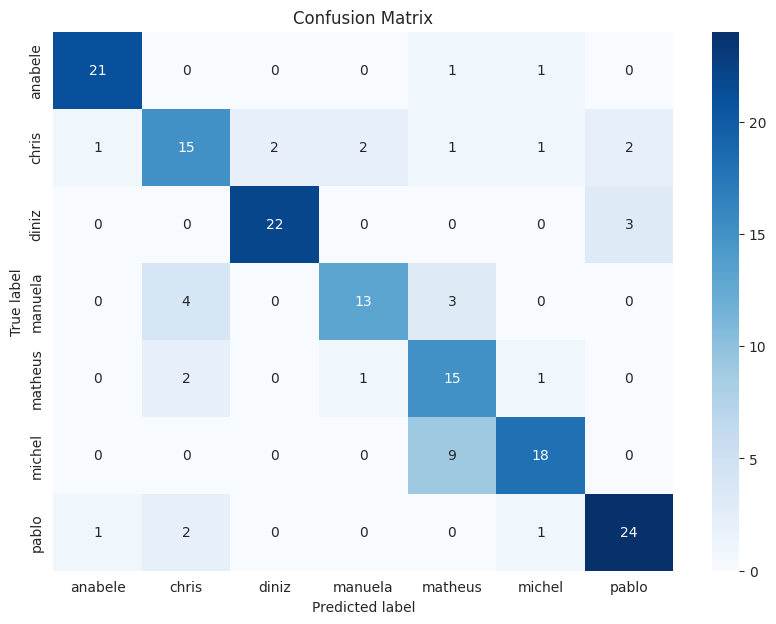

In [22]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.metrics import confusion_matrix

# get the confusion matrix
matrix = confusion_matrix(true_classes, predicted_classes)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Pré-processamento Detecção de Bordas e Bootstrap

In [17]:
import cv2

# Definindo o pré-processamento para geração de dados
def realcar_tatuagem(imagem):
    # Converter a imagem para escala de cinza
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY).astype('uint8')

    # Aplicar suavização bilateral para preservar as bordas da tatuagem
    imagem_suavizada = cv2.bilateralFilter(imagem_cinza, 9, 75, 75)

    # Detectar as bordas na imagem suavizada
    bordas = cv2.Canny(imagem_suavizada, 30, 50)

    # Criar um kernel para dilatação
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # Dilatar as bordas para melhorar a detecção da tatuagem
    bordas_dilatadas = cv2.dilate(bordas, kernel, iterations=1)

    # Aplicar thresholding para criar uma máscara binária das bordas
    _, mascara = cv2.threshold(bordas_dilatadas, 30, 255, cv2.THRESH_BINARY)

    # Aplicar a máscara na imagem original para realçar a tatuagem
    imagem_realcada = cv2.bitwise_and(imagem, imagem, mask=mascara)

    processed_image = tf.keras.applications.vgg19.preprocess_input(imagem_realcada)
    return processed_image

datagen_db = tf.keras.preprocessing.image.ImageDataGenerator( #rotation_range=40,          # Rotação aleatória das imagens em até 40 graus
                              #width_shift_range=0.2,      # Deslocamento horizontal aleatório das imagens em até 20% da largura
                              #height_shift_range=0.2,     # Deslocamento vertical aleatório das imagens em até 20% da altura
                              #shear_range=0.2,            # Aplicação de corte nas imagens
                              #zoom_range=0.2,             # Aplicação de zoom nas imagens
                              #horizontal_flip=True,       # Inversão horizontal das imagens
                              #fill_mode='nearest',
                              preprocessing_function=realcar_tatuagem)#vgg19.preprocess_input)

**Salvando o Modelo e Utilização do EarlyStop**

In [18]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_pre_db = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_pre_db = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_pre_db.weights.h5',
                                            save_best_only=True,
                                            save_weights_only=True,
                                            verbose=1)

# EarlyStopping
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     patience=10,
                                     restore_best_weights=True,
                                     mode='min')

**Função para Aplicar o Pré-processamento de Suavização nas Imagens**

In [19]:
# Treinamento do gerador de dados
train_generator_db = datagen_db.flow_from_directory(
    base_dir + '/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# Validação do gerador de dados
validation_generator_db = datagen_db.flow_from_directory(
    base_dir + '/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

# Teste do gerador de dados
test_generator_db = datagen_db.flow_from_directory(
    base_dir + '/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.
Found 166 images belonging to 7 classes.


In [16]:
# Use a smaller learning rate
#optim = Adam(lr=0.0001)

# Just Feature Extraction
vgg_model_db = create_model(input_shape, n_classes, optim_1, fine_tune=0)

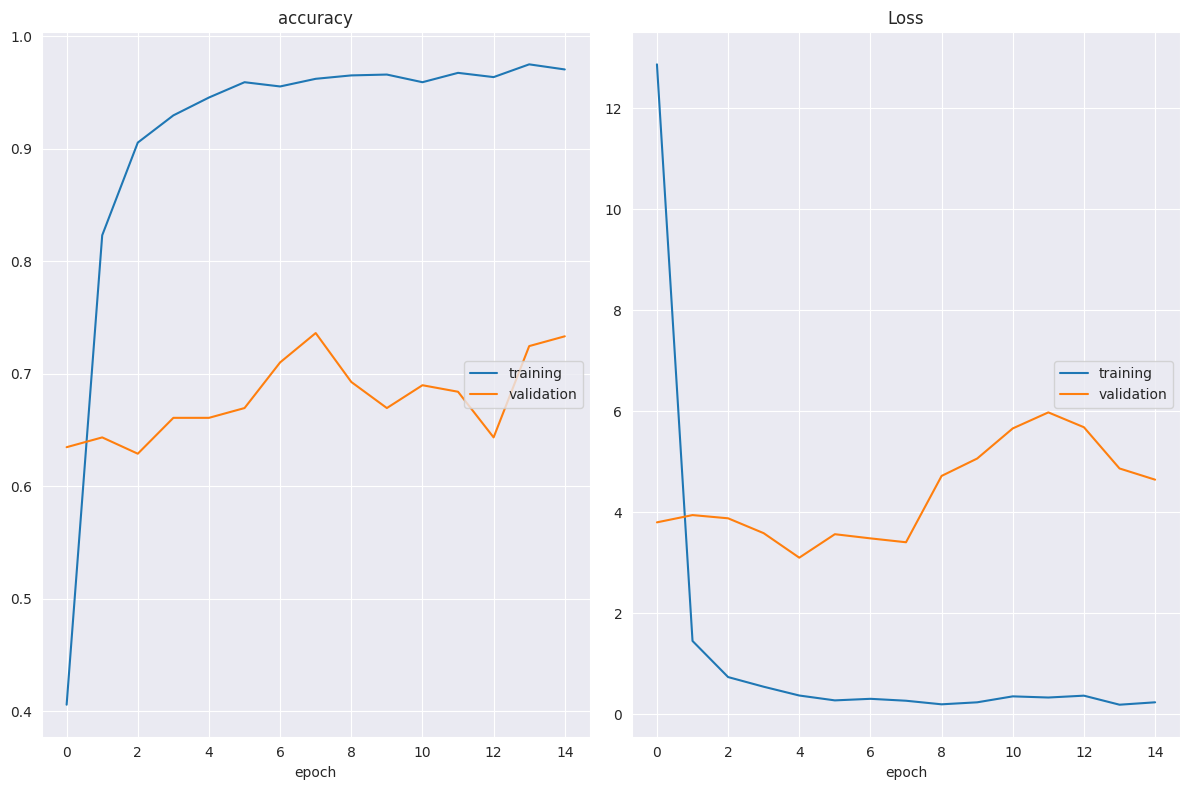

accuracy
	training         	 (min:    0.406, max:    0.975, cur:    0.971)
	validation       	 (min:    0.629, max:    0.736, cur:    0.733)
Loss
	training         	 (min:    0.189, max:   12.868, cur:    0.236)
	validation       	 (min:    3.100, max:    5.977, cur:    4.645)
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.9651 - loss: 0.3398 - val_accuracy: 0.7333 - val_loss: 4.6448
CPU times: user 4min 23s, sys: 1min 37s, total: 6min 1s
Wall time: 3min 22s


In [22]:
%%time

plot_loss = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_db = vgg_model_db.fit(train_generator_db,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_generator_db,
                                  callbacks=[tl_checkpoint_pre_db, early_stop, plot_loss],
                                  verbose=1)

**Acurácia de Teste**

In [23]:
#from sklearn.metrics import accuracy_score

vgg_model_db.load_weights('./modelsaved/tl_model_pre_db.weights.h5')
vgg_preds_db = vgg_model_db.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes = np.argmax(vgg_preds_db, axis=1)
print(predicted_classes)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy = np.mean(predicted_classes == true_classes)
print(accuracy)

accuracy_sk = accuracy_score(true_classes, predicted_classes)
print(accuracy_sk)

print(f"Acurácia: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 621ms/step
[5 3 4 6 4 4 5 5 2 2 2 4 4 4 5 5 4 5 4 4 5 5 4 4 4 5 2 5 5 5 2 5 2 5 5 5 5
 2 5 5 5 2 6 2 5 5 1 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 3 6
 3 5 5 5 3 5 3 3 4 3 5 3 3 3 5 4 3 5 4 5 5 4 4 4 5 5 4 4 4 4 4 4 4 4 5 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 2 6 5 2 6 5 5 2
 5 6 5 5 6 2 5 5 5 6 2 5 5 5 6 6 4 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.4879518072289157
0.4879518072289157
Acurácia: 48.80%


**Matriz de Confusão**

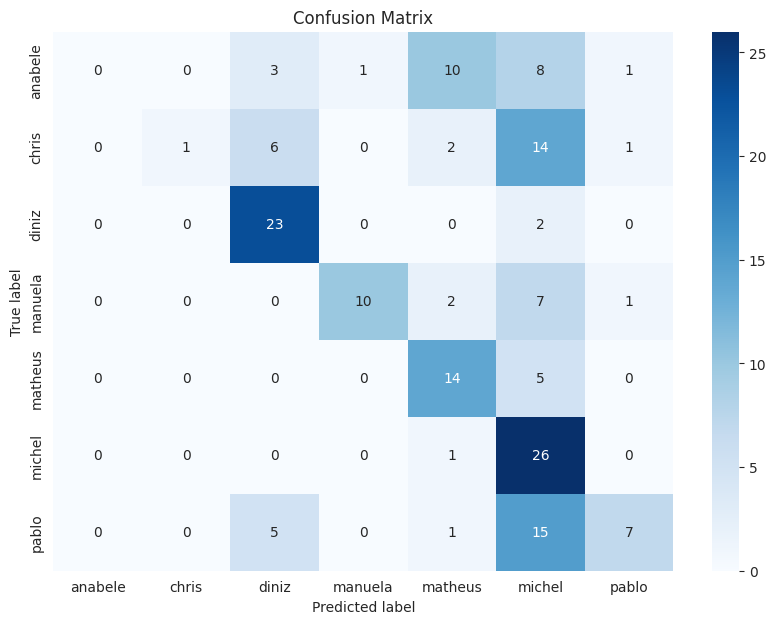

In [25]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.metrics import confusion_matrix

# get the confusion matrix
matrix = confusion_matrix(true_classes, predicted_classes)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Pré-processamento de Detecção de Bordas e Fine Tuning

**Salvando o Modelo e Utilização do EarlyStop**

In [20]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_pre_db = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_pre_db = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_pre_db_ft.weights.h5',
                                            save_best_only=True,
                                            save_weights_only=True,
                                            verbose=1)

# EarlyStopping
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     patience=10,
                                     restore_best_weights=True,
                                     mode='min')

In [21]:
# Use a smaller learning rate
#optim = Adam(lr=0.0001)

# Just Feature Extraction
vgg_model_db = create_model(input_shape, n_classes, optim_1, fine_tune=3)

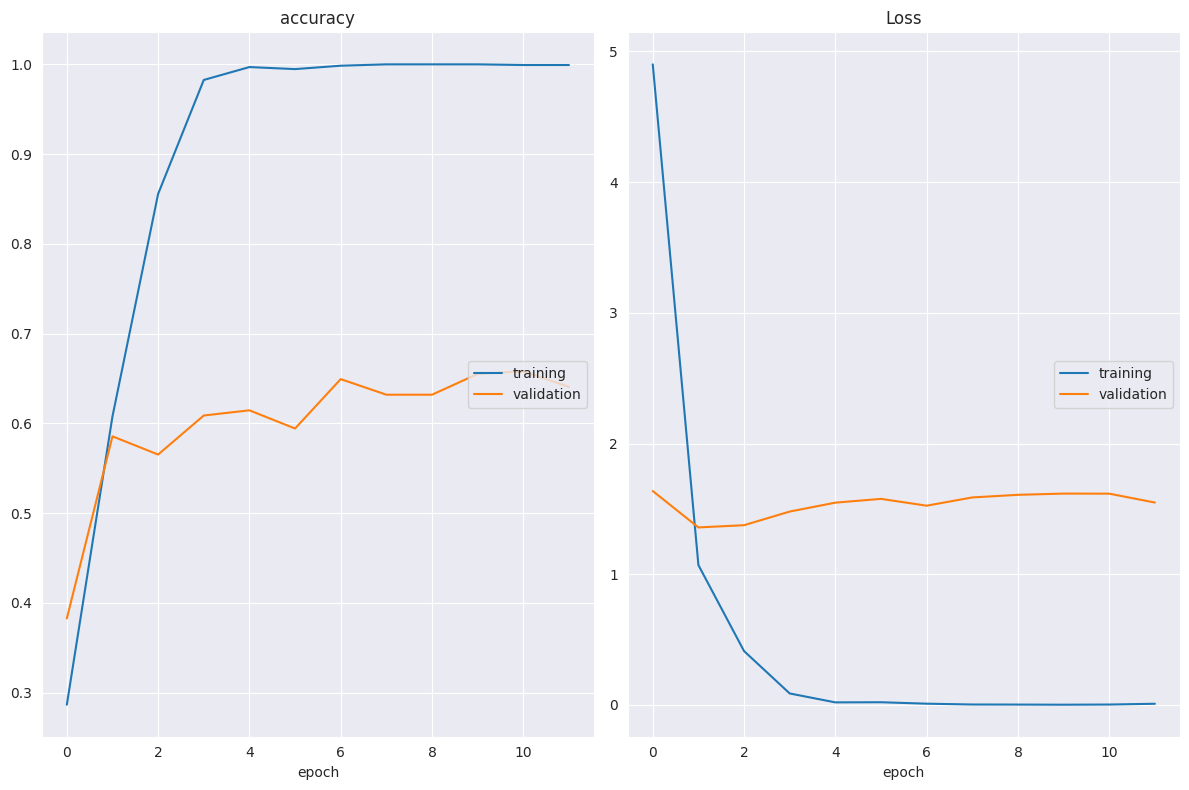

accuracy
	training         	 (min:    0.286, max:    1.000, cur:    0.999)
	validation       	 (min:    0.383, max:    0.658, cur:    0.641)
Loss
	training         	 (min:    0.002, max:    4.901, cur:    0.009)
	validation       	 (min:    1.358, max:    1.636, cur:    1.548)
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.9976 - loss: 0.0219 - val_accuracy: 0.6406 - val_loss: 1.5484
CPU times: user 3min 40s, sys: 1min 20s, total: 5min
Wall time: 2min 50s


In [22]:
%%time

plot_loss = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_db = vgg_model_db.fit(train_generator_db,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_generator_db,
                                  callbacks=[tl_checkpoint_pre_db, early_stop, plot_loss],
                                  verbose=1)

**Acurácia de Teste**

In [23]:
#from sklearn.metrics import accuracy_score

vgg_model_db.load_weights('./modelsaved/tl_model_pre_db_ft.weights.h5')
vgg_preds_db = vgg_model_db.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes = np.argmax(vgg_preds_db, axis=1)
print(predicted_classes)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy = np.mean(predicted_classes == true_classes)
print(accuracy)

accuracy_sk = accuracy_score(true_classes, predicted_classes)
print(accuracy_sk)

print(f"Acurácia: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 583ms/step
[0 5 4 5 0 4 5 5 6 4 2 5 5 6 5 5 3 0 4 0 5 5 0 5 5 1 5 0 5 5 5 5 6 5 5 4 3
 5 5 5 5 2 5 6 5 5 5 5 2 5 6 2 5 2 2 5 2 2 6 2 5 2 5 2 4 5 2 5 2 5 6 2 3 5
 5 5 5 5 3 3 5 5 5 3 5 5 5 3 5 3 5 5 5 5 5 5 5 5 5 5 4 4 5 5 0 5 5 5 5 5 5
 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 6 5 5 5 5 5 5 5
 5 5 6 5 5 2 6 5 5 6 6 5 5 5 5 5 6 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.3433734939759036
0.3433734939759036
Acurácia: 34.34%


**Matriz de Confusão**

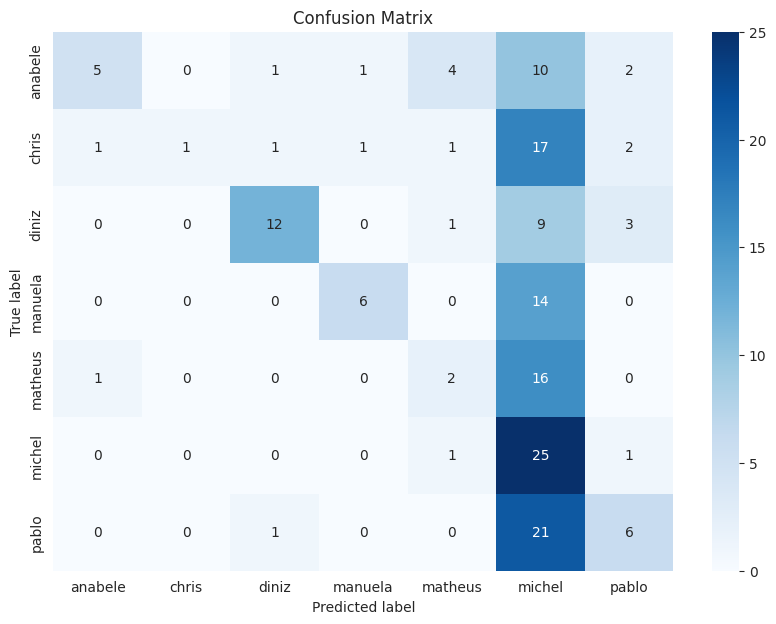

In [25]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.metrics import confusion_matrix

# get the confusion matrix
matrix = confusion_matrix(true_classes, predicted_classes)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Data Augmentation - Bootstrap

**Realização de Data Augmentation**

O Data Augmentation foi aplicado apenas nos dados de treinamento e validação. Os dados de testes não devem passar por este método.

In [24]:
train_DataAugmentation = tf.keras.preprocessing.image.ImageDataGenerator( 
    brightness_range=[1.5, 0.7],    # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,          # shift the width of the image 50%
    rotation_range=90,             # random rotation by 90 degrees
    horizontal_flip=True,          # 180 degree flip horizontally
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input)          # 15% of the data will be used for validation at end of each epoch


In [15]:
training_da = train_DataAugmentation.flow_from_directory(
    base_dir + '/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

validation_da = train_DataAugmentation.flow_from_directory(
    base_dir + '/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.


**Salvando os Pesos**

In [16]:
plot_loss_5 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_5 = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_preprocess_da.weights.h5',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

In [17]:
# Reset our image data generators
#train_generator_pre.reset() 
#validation_generator_pre.reset() 
#test_generator_pre.reset()

#optim_4 = Adam(learning_rate=0.0001)

# Just Feature Extraction
vgg_model_ft_5 = create_model(input_shape, n_classes, optim_1, fine_tune=0)

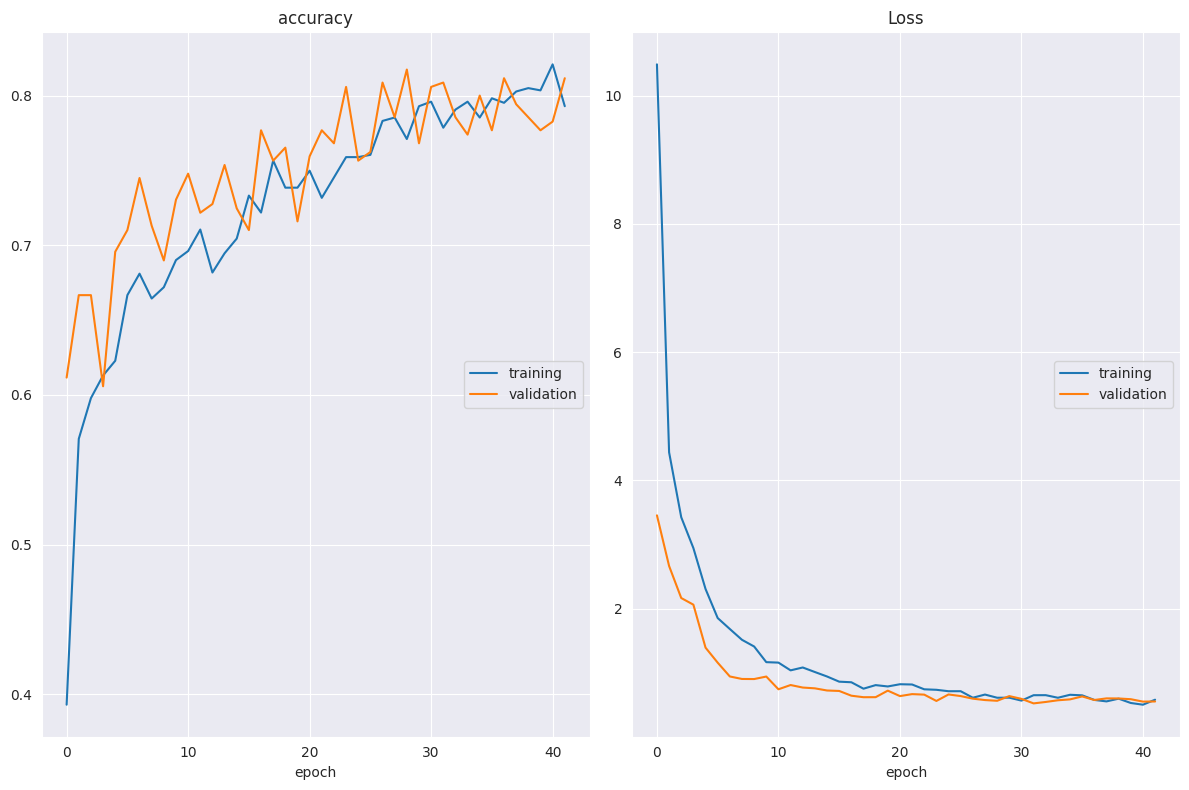

accuracy
	training         	 (min:    0.393, max:    0.821, cur:    0.793)
	validation       	 (min:    0.606, max:    0.817, cur:    0.812)
Loss
	training         	 (min:    0.502, max:   10.488, cur:    0.580)
	validation       	 (min:    0.523, max:    3.455, cur:    0.553)
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - accuracy: 0.8060 - loss: 0.5828 - val_accuracy: 0.8116 - val_loss: 0.5528
CPU times: user 13min 28s, sys: 35.3 s, total: 14min 3s
Wall time: 9min 55s


In [18]:
%%time

plot_loss_pre_da = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_5 = vgg_model_ft_5.fit(training_da,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_da,
                                  callbacks=[tl_checkpoint_5, early_stop, plot_loss_pre_da],
                                  verbose=1)

tf.keras.backend.clear_session(free_memory=True)

**Acurácia de Teste**

In [19]:
from sklearn.metrics import accuracy_score

vgg_model_ft_5.load_weights('./modelsaved/tl_model_preprocess_da.weights.h5')
vgg_preds_ft_5 = vgg_model_ft_5.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes_5 = np.argmax(vgg_preds_ft_5, axis=1)
print(predicted_classes_5)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy_5 = np.mean(predicted_classes_5 == true_classes)
print(accuracy_5)

accuracy_sk_5 = accuracy_score(true_classes, predicted_classes_5)
print(accuracy_sk_5)

print(f"Acurácia: {accuracy_5 * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 1 1 1 1 2 1 6 6 1 1 5
 1 1 1 1 3 1 1 5 5 1 2 2 2 2 2 6 2 2 6 2 2 6 2 2 2 2 2 6 2 2 2 0 2 2 2 3 3
 4 3 3 1 3 3 3 3 3 3 3 3 3 3 1 3 3 3 4 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 3 4 5 5 5 5 5 5 5 5 5 5 4 4 4 5 3 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.8433734939759037
0.8433734939759037
Acurácia: 84.34%


**Matriz de Confusão**

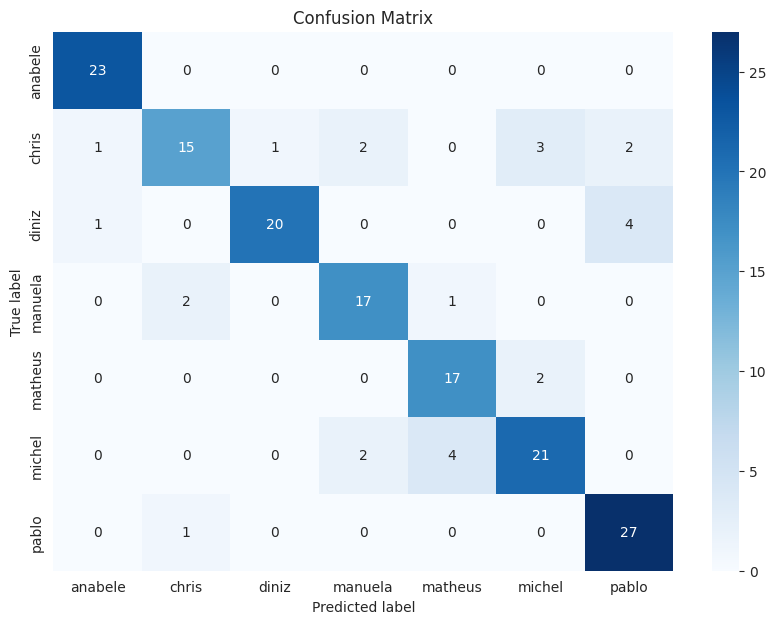

In [20]:
# get the confusion matrix
matrix_5 = confusion_matrix(true_classes, predicted_classes_5)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_5, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Data Augmentation - Fine Tuning

**Realização de Data Augmentation**

O Data Augmentation foi aplicado apenas nos dados de treinamento e validação. Os dados de testes não devem passar por este método.

In [20]:
train_DataAugmentation_ft = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=[1.5, 0.7],    # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,          # shift the width of the image 50%
    rotation_range=90,             # random rotation by 90 degrees
    horizontal_flip=True,          # 180 degree flip horizontally
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input)          # 15% of the data will be used for validation at end of each epoch


In [21]:
training_da_ft = train_DataAugmentation_ft.flow_from_directory(
    base_dir + '/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

validation_da_ft = train_DataAugmentation_ft.flow_from_directory(
    base_dir + '/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.


**Salvando os Pesos**

In [22]:
plot_loss_6 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_6 = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_preprocess_da_ft.weights.h5',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

In [23]:
# Reset our image data generators
#train_generator_pre.reset() 
#validation_generator_pre.reset() 
#test_generator_pre.reset()

#optim_4 = Adam(learning_rate=0.0001)

# Just Feature Extraction
vgg_model_ft_6 = create_model(input_shape, n_classes, optim_1, fine_tune=3)

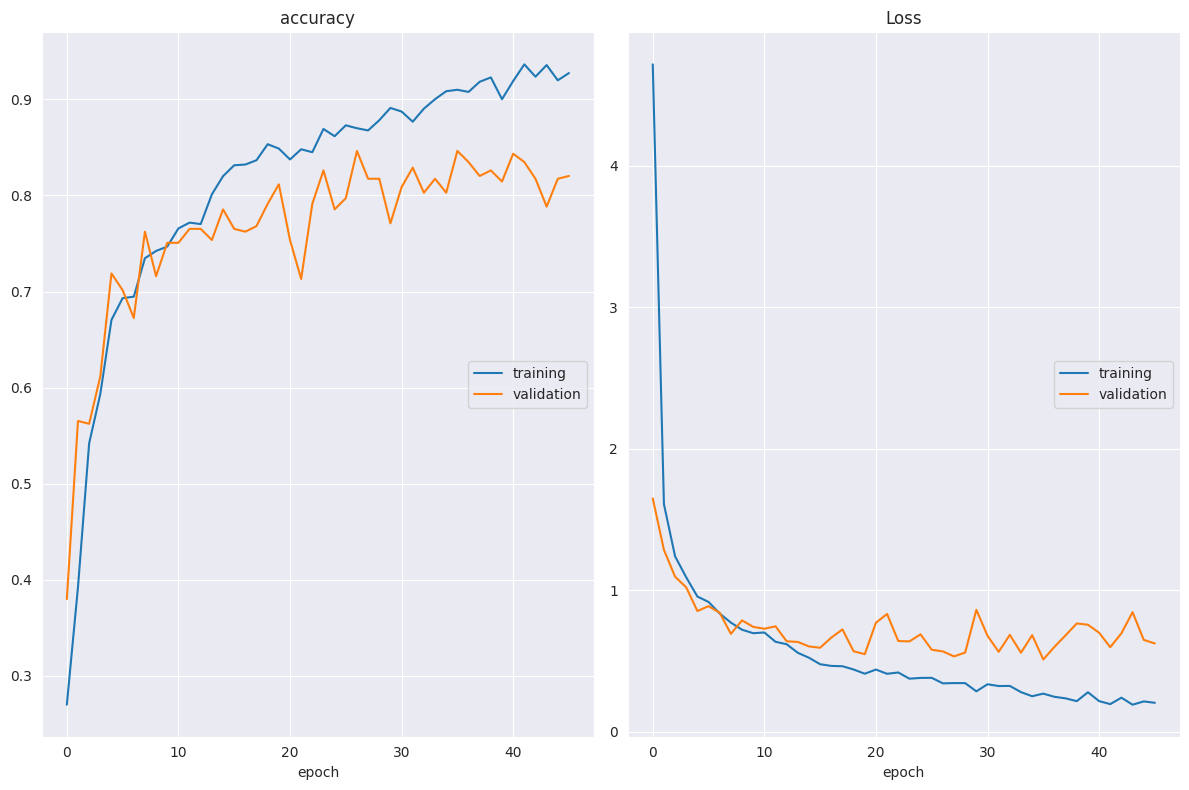

accuracy
	training         	 (min:    0.270, max:    0.937, cur:    0.927)
	validation       	 (min:    0.380, max:    0.846, cur:    0.820)
Loss
	training         	 (min:    0.193, max:    4.718, cur:    0.206)
	validation       	 (min:    0.512, max:    1.650, cur:    0.625)
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9350 - loss: 0.1890 - val_accuracy: 0.8203 - val_loss: 0.6254
CPU times: user 15min 5s, sys: 36.6 s, total: 15min 41s
Wall time: 10min 58s


In [24]:
%%time

plot_loss_pre_da_ft = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_6 = vgg_model_ft_6.fit(training_da_ft,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_da_ft,
                                  callbacks=[tl_checkpoint_6, early_stop, plot_loss_pre_da_ft],
                                  verbose=1)

tf.keras.backend.clear_session(free_memory=True)

**Acurácia de Teste**

In [27]:
from sklearn.metrics import accuracy_score

vgg_model_ft_6.load_weights('./modelsaved/tl_model_preprocess_da_ft.weights.h5')
vgg_preds_ft_6 = vgg_model_ft_6.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes_6 = np.argmax(vgg_preds_ft_6, axis=1)
print(predicted_classes_6)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy_6 = np.mean(predicted_classes_6 == true_classes)
print(accuracy_6)

accuracy_sk_6 = accuracy_score(true_classes, predicted_classes_6)
print(accuracy_sk_6)

print(f"Acurácia: {accuracy_6 * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 1 1 1 1 3 1 1 4 1 1 1
 3 1 3 3 3 1 1 4 4 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 4 5 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4
 4 5 5 5 5 5 4 5 5 5 5 5 4 5 5 4 5 5 5 4 4 3 5 5 4 5 5 6 6 6 6 6 6 6 6 6 6
 6 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.8614457831325302
0.8614457831325302
Acurácia: 86.14%


**Matriz de Confusão**

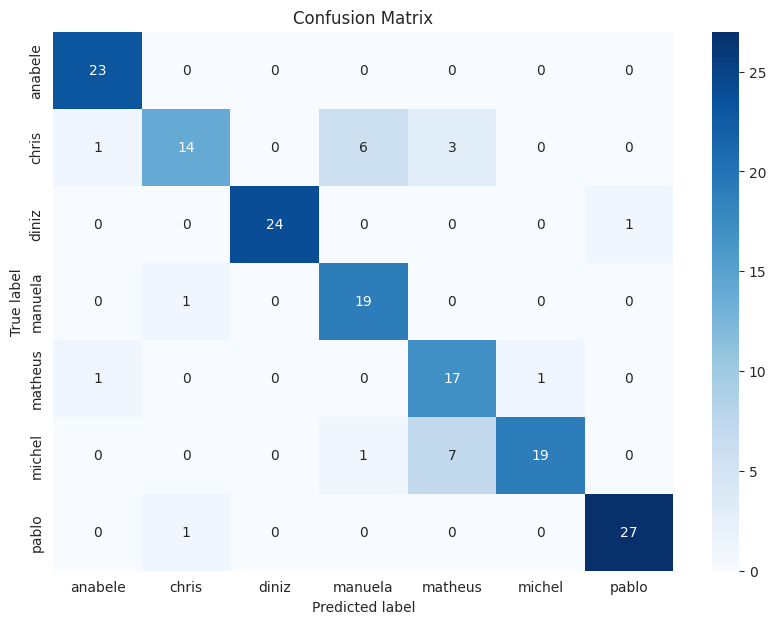

In [29]:
# get the confusion matrix
matrix_6 = confusion_matrix(true_classes, predicted_classes_6)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_6, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Bootstrap - Data Augmentation e Pré-processamento de Realce

**Realização de Data Augmentation**

O Data Augmentation foi aplicado apenas nos dados de treinamento e validação. Os dados de testes não devem passar por este método.

In [17]:
train_DataAugmentation_pre = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=[1.5, 0.7],    # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,          # shift the width of the image 50%
    rotation_range=90,             # random rotation by 90 degrees
    horizontal_flip=True,          # 180 degree flip horizontally
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input)          # 15% of the data will be used for validation at end of each epoch


In [18]:
training_da_ft = train_DataAugmentation_pre.flow_from_directory(
    base_dir_pre + '/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

validation_da_ft = train_DataAugmentation_pre.flow_from_directory(
    base_dir_pre + '/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.


**Salvando os Pesos**

In [19]:
plot_loss_6 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_6 = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_preprocess_da_pre.weights.h5',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

In [20]:
# Reset our image data generators
#train_generator_pre.reset() 
#validation_generator_pre.reset() 
#test_generator_pre.reset()

#optim_4 = Adam(learning_rate=0.0001)

# Just Feature Extraction
vgg_model_ft_6 = create_model(input_shape, n_classes, optim_1, fine_tune=3)

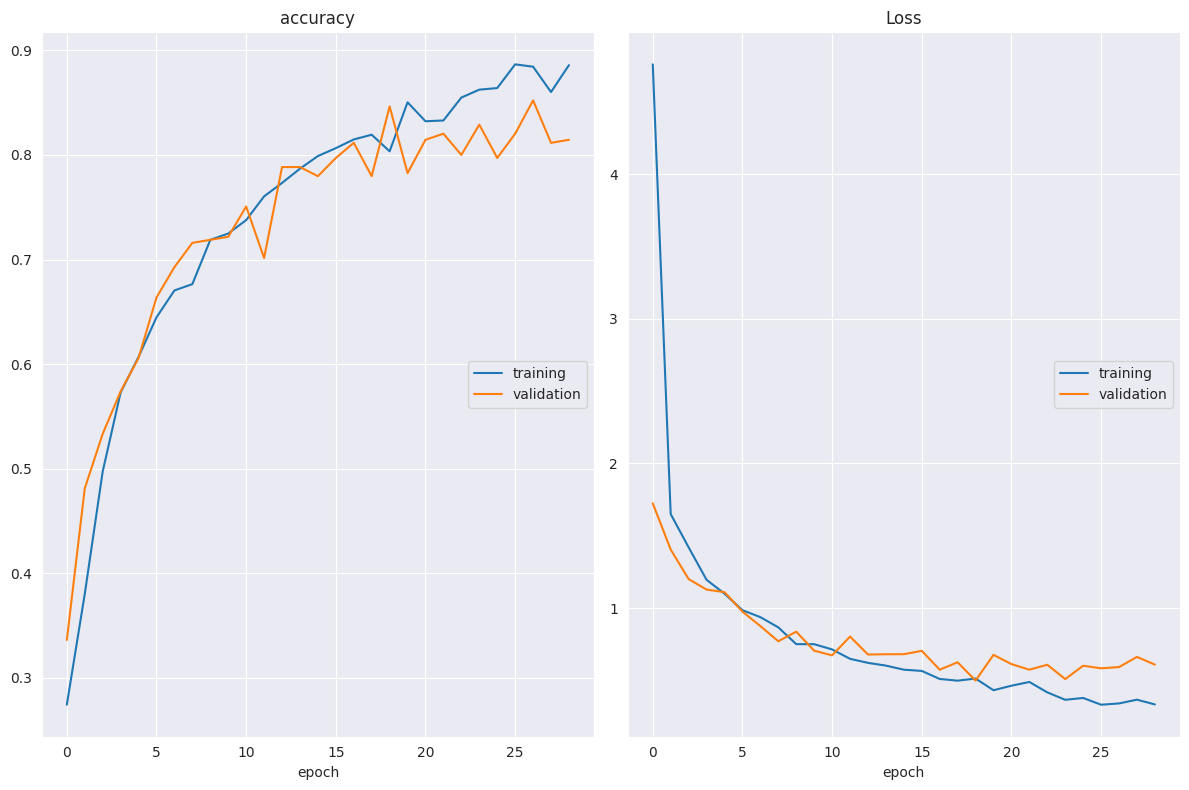

accuracy
	training         	 (min:    0.274, max:    0.887, cur:    0.886)
	validation       	 (min:    0.336, max:    0.852, cur:    0.814)
Loss
	training         	 (min:    0.332, max:    4.759, cur:    0.334)
	validation       	 (min:    0.499, max:    1.724, cur:    0.609)
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.8850 - loss: 0.3434 - val_accuracy: 0.8145 - val_loss: 0.6091
CPU times: user 9min 43s, sys: 30.8 s, total: 10min 13s
Wall time: 7min 51s


In [21]:
%%time

plot_loss_pre_da_ft = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_6 = vgg_model_ft_6.fit(training_da_ft,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_da_ft,
                                  callbacks=[tl_checkpoint_6, early_stop, plot_loss_pre_da_ft],
                                  verbose=1)

tf.keras.backend.clear_session(free_memory=True)

**Acurácia de Teste**

In [23]:
from sklearn.metrics import accuracy_score

vgg_model_ft_6.load_weights('./modelsaved/tl_model_preprocess_da_pre.weights.h5')
vgg_preds_ft_6 = vgg_model_ft_6.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes_6 = np.argmax(vgg_preds_ft_6, axis=1)
print(predicted_classes_6)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy_6 = np.mean(predicted_classes_6 == true_classes)
print(accuracy_6)

accuracy_sk_6 = accuracy_score(true_classes, predicted_classes_6)
print(accuracy_sk_6)

print(f"Acurácia: {accuracy_6 * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 1 1 1 1 1 1 1 1 1 1 3
 3 1 2 3 3 1 1 3 4 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 4 5 4 5 3 4 4 4 4 4 5 1 4 4 4 4 4 4 3
 4 4 5 5 5 5 4 4 5 5 4 5 3 5 5 6 5 5 5 5 5 3 5 5 4 4 5 6 0 6 6 6 6 6 6 6 6
 6 1 6 6 6 2 6 6 6 6 6 1 6 6 6 6 6 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.8072289156626506
0.8072289156626506
Acurácia: 80.72%


**Matriz de Confusão**

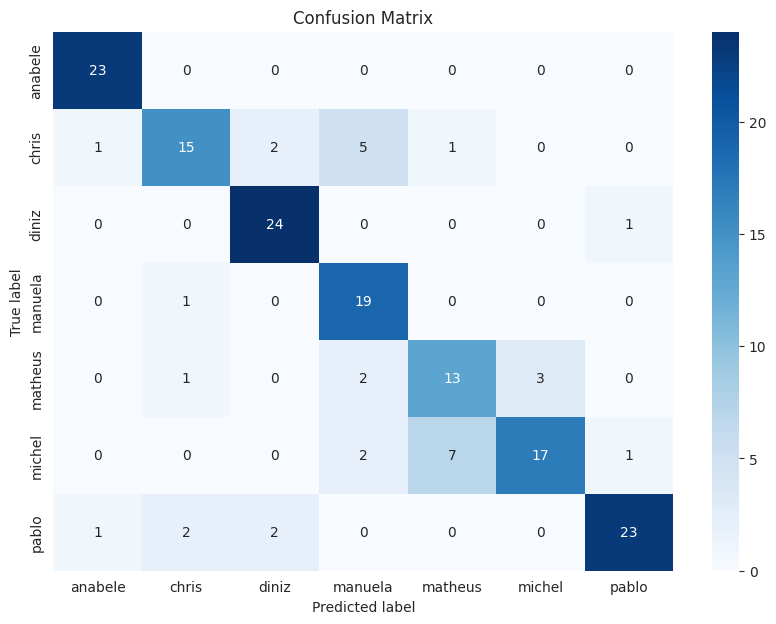

In [24]:
# get the confusion matrix
matrix_6 = confusion_matrix(true_classes, predicted_classes_6)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_6, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Fine Tuning - Data Augmentation e Pré-processamento de Realce

**Realização de Data Augmentation**

O Data Augmentation foi aplicado apenas nos dados de treinamento e validação. Os dados de testes não devem passar por este método.

In [21]:
train_DataAugmentation_pre = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=[1.5, 0.7],    # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,          # shift the width of the image 50%
    rotation_range=90,             # random rotation by 90 degrees
    horizontal_flip=True,          # 180 degree flip horizontally
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input)          # 15% of the data will be used for validation at end of each epoch


In [23]:
training_da_ft = train_DataAugmentation_pre.flow_from_directory(
    base_dir_pre + '/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

validation_da_ft = train_DataAugmentation_pre.flow_from_directory(
    base_dir_pre + '/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.


**Salvando os Pesos**

In [24]:
plot_loss_6 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_6 = callbacks.ModelCheckpoint(filepath='./modelsaved/tl_model_preprocess_da_pre.weights.h5',
                                  save_best_only=True,
                                  save_weights_only=True,
                                  verbose=1)

In [25]:
# Reset our image data generators
#train_generator_pre.reset() 
#validation_generator_pre.reset() 
#test_generator_pre.reset()

#optim_4 = Adam(learning_rate=0.0001)

# Just Feature Extraction
vgg_model_ft_6 = create_model(input_shape, n_classes, optim_1, fine_tune=3)

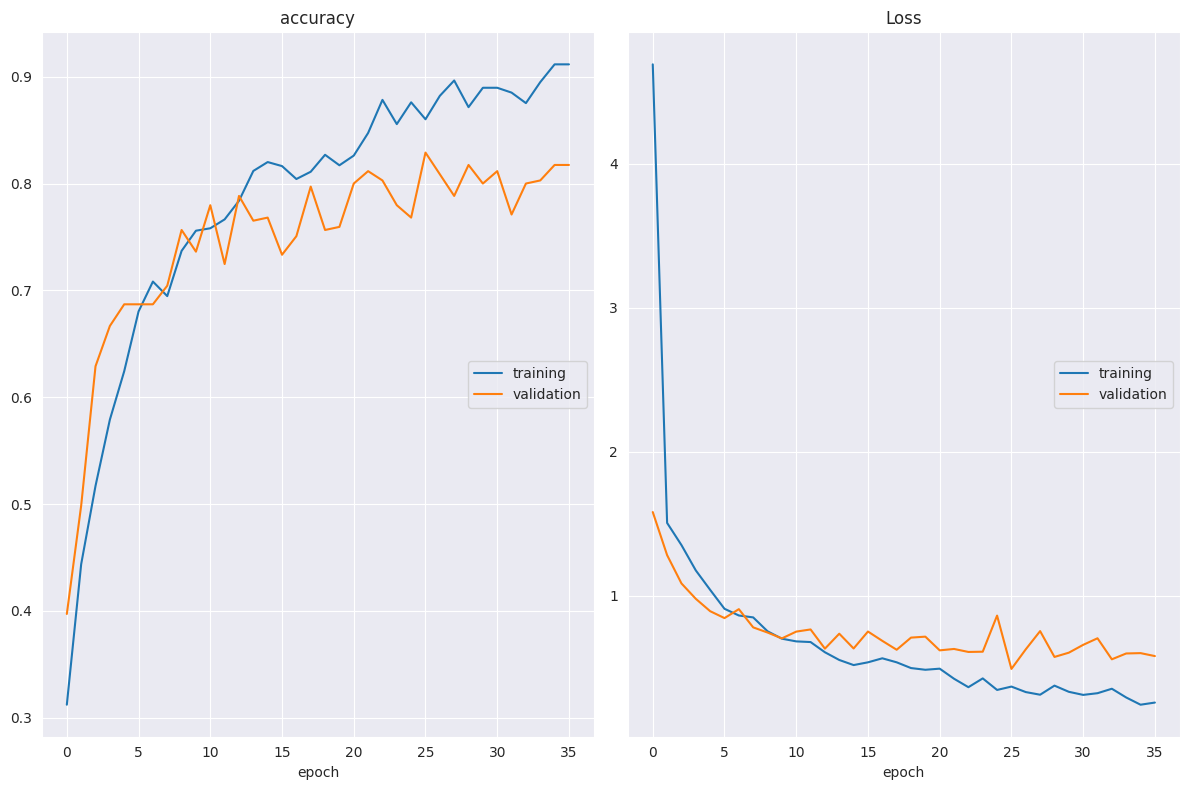

accuracy
	training         	 (min:    0.312, max:    0.912, cur:    0.912)
	validation       	 (min:    0.397, max:    0.829, cur:    0.817)
Loss
	training         	 (min:    0.244, max:    4.690, cur:    0.259)
	validation       	 (min:    0.493, max:    1.582, cur:    0.582)
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - accuracy: 0.9106 - loss: 0.2743 - val_accuracy: 0.8174 - val_loss: 0.5817
CPU times: user 11min 51s, sys: 39.4 s, total: 12min 31s
Wall time: 9min 39s


In [26]:
%%time

plot_loss_pre_da_ft = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history_6 = vgg_model_ft_6.fit(training_da_ft,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validation_da_ft,
                                  callbacks=[tl_checkpoint_6, early_stop, plot_loss_pre_da_ft],
                                  verbose=1)

tf.keras.backend.clear_session(free_memory=True)

**Acurácia de Teste**

In [27]:
from sklearn.metrics import accuracy_score

vgg_model_ft_6.load_weights('./modelsaved/tl_model_preprocess_da_pre.weights.h5')
vgg_preds_ft_6 = vgg_model_ft_6.predict(test_generator)

# determina as classes previstas (retorna a classe com a maior probabilidade)
predicted_classes_6 = np.argmax(vgg_preds_ft_6, axis=1)
print(predicted_classes_6)

# recupera as classes verdadeiras do test_generator
true_classes = test_generator.classes
print(true_classes)

# calcula a acurácia
accuracy_6 = np.mean(predicted_classes_6 == true_classes)
print(accuracy_6)

accuracy_sk_6 = accuracy_score(true_classes, predicted_classes_6)
print(accuracy_sk_6)

print(f"Acurácia: {accuracy_6 * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 620ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 3 1 3 3 6 2 1 1 1
 3 1 2 3 3 1 1 1 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 4 5 4 4 3 4 3 1 4 4 5 4 4 4 4 4 4 4 4
 5 5 5 5 5 3 4 5 5 5 5 5 3 5 5 5 5 5 5 4 5 3 5 5 4 5 5 6 6 6 6 6 6 6 6 6 6
 6 1 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0.8493975903614458
0.8493975903614458
Acurácia: 84.94%


**Matriz de Confusão**

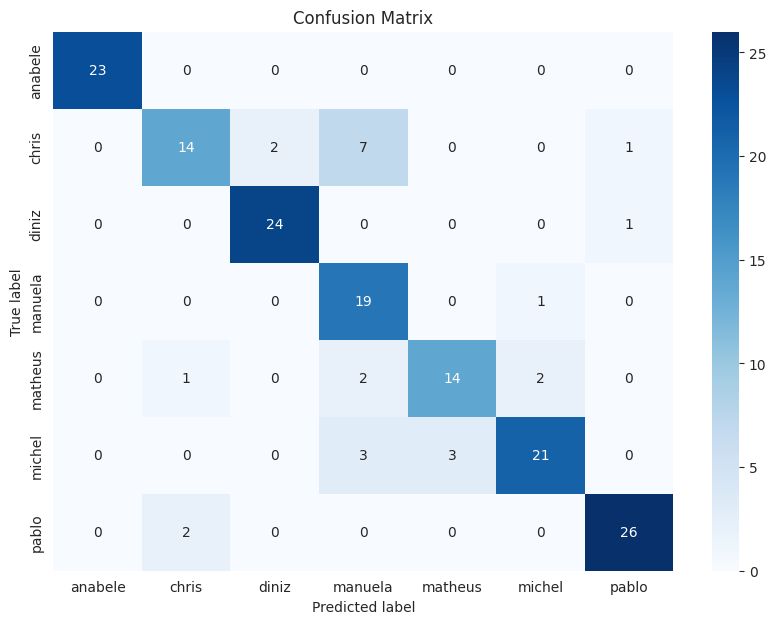

In [28]:
# get the confusion matrix
matrix_6 = confusion_matrix(true_classes, predicted_classes_6)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_6, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()